# Mounting GDrive directory

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Colab Notebooks/UoA_MSDS/Course_8/Capstone1_Ad_Campaign_Recommender/'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/UoA_MSDS/Course_8/Capstone1_Ad_Campaign_Recommender


# Import libraries

In [2]:
%pip install basemap dill --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 860.7/860.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 41.4 MB/s eta 0:00:00


In [3]:
import os
import csv

from IPython.core.display import display, HTML

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import DBSCAN

# Reading data

The datasets below are already downloaded from previous notebook:
- [app_events.csv](https://uoacapstone.s3.amazonaws.com/app_events.csv)
- [train_event_data.csv](https://uoacapstone.s3.amazonaws.com/train_event_data.csv)
- [app_events_meta_data.csv](https://uoacapstone.s3.amazonaws.com/app_events_meta_data.csv)
- [train_mobile_brand.csv](https://uoacapstone.s3.amazonaws.com/train_mobile_brand.csv)

In [4]:
# Load into dataframes, disble quote parsing inside strings when loading
# Ref: https://stackoverflow.com/a/29857126

app_events = pd.read_csv('data/app_events.csv', quoting=csv.QUOTE_NONE)
train_event_data = pd.read_csv('data/train_event_data.csv', quoting=csv.QUOTE_NONE)
app_events_meta_data = pd.read_csv('data/app_events_meta_data.csv', quoting=csv.QUOTE_NONE)
train_mobile_brand = pd.read_csv('data/train_mobile_brand.csv', quoting=csv.QUOTE_NONE)

# Features from feature engineering section
feature_average_daily_events = pd.read_csv('data/feature_average_daily_events.csv', quoting=csv.QUOTE_NONE)

# Subtask 4: Advanced visualization and clustering

## 1. Geospatial visualization

### a) Plot the visualization plot for a sample of 100'000 data points

In [5]:
# Map plot function

def map_plot(data, color=None, region_config=None):
  plt.figure(figsize=(16,6))

  if not region_config:
    m = Basemap()
  else:
    m = Basemap(
        projection='merc',
        llcrnrlat=region_config['lat_min'],
        urcrnrlat=region_config['lat_max'],
        llcrnrlon=region_config['lon_min'],
        urcrnrlon=region_config['lon_max'],
        lat_ts=35,
        resolution='c'
    )
  m.shadedrelief()
  m.drawcoastlines(linewidth=.1)
  m.drawcountries(linewidth=.1)

  m.scatter(
      *m(data.longitude, data.latitude),
      marker='o',
      s=3,
      color= color or 'r',
  )

  plt.show()
  plt.clf()
  plt.close("all")

In [6]:
# Get 100'000 sample points
sample_locations = train_event_data[~(train_event_data.latitude.isna() | train_event_data.longitude.isna())].sample(int(1e5))
sample_locations

,device_id,gender,age,group_train,event_id,datetimestamp,latitude,longitude
505392,1059108490518970000,M,29,M25-32,2711276.0,2016-05-01 23:27:18,31.80,104.74
870788,-1002733576670970000,M,47,M32+,210973.0,2016-05-03 21:38:02,0.00,0.00
65851,118276158630381000,M,18,M0-24,2013506.0,2016-05-01 03:40:37,23.07,114.11
832193,-8241952332260660000,M,19,M0-24,253577.0,2016-05-02 14:35:53,37.20,116.47
800736,5371847614880380000,M,26,M25-32,13511.0,2016-05-04 13:12:42,27.32,103.71
...,...,...,...,...,...,...,...,...
272192,-3845046065455220000,M,27,M25-32,3191238.0,2016-05-01 09:51:24,33.57,114.03
1079938,9163721051841010000,M,31,M25-32,687525.0,2016-05-03 19:28:03,0.00,0.00
1160273,-1319995297521480000,M,31,M25-32,2221899.0,2016-05-07 21:38:27,29.87,121.63
756893,-9122745692722600000,M,36,M32+,497795.0,2016-05-04 07:12:30,31.77,119.93


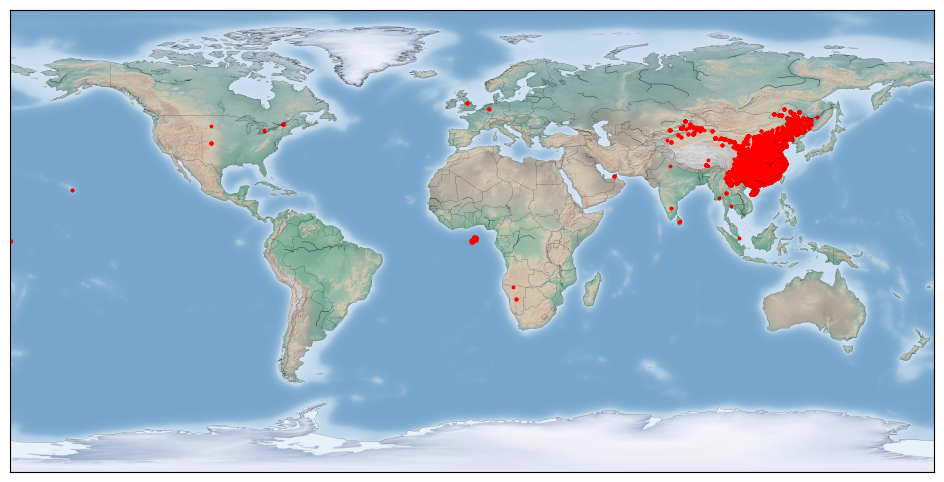

In [7]:
map_plot(sample_locations)

Most of the events are from East Asia. Let's narrow down to the region with most events.

In [8]:
lat_min, lat_max = 15, 55
lon_min, lon_max = 70, 140
region_config = dict(lat_min=lat_min, lat_max=lat_max, lon_min=lon_min, lon_max=lon_max)

idx = (
    (~(train_event_data['latitude'].isna() | train_event_data['longitude'].isna())) &
    (train_event_data['latitude'] > lat_min) &
    (train_event_data['latitude'] < lat_max) &
    (train_event_data['longitude'] > lon_min) &
    (train_event_data['longitude'] < lon_max)
)
regional_locations = train_event_data[idx]
sample_regional_locations = regional_locations.sample(int(1e5))

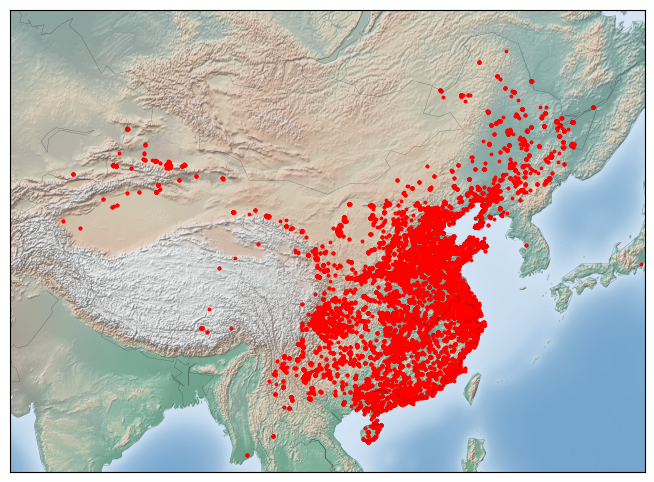

In [9]:
map_plot(sample_regional_locations, region_config=region_config)

### b) Compare the event visualization plots based on the users' gender information

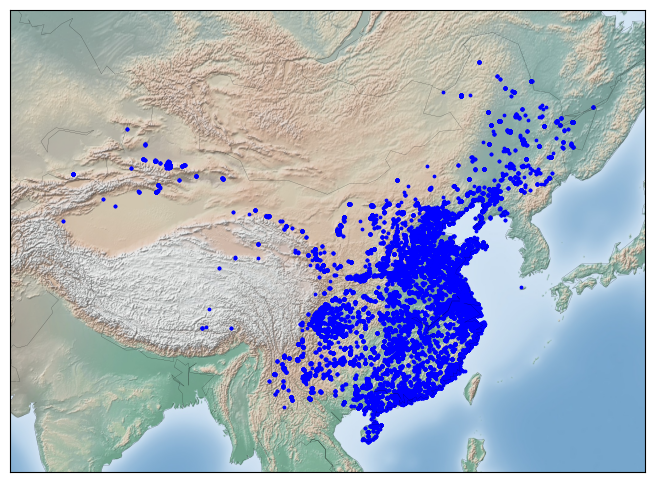

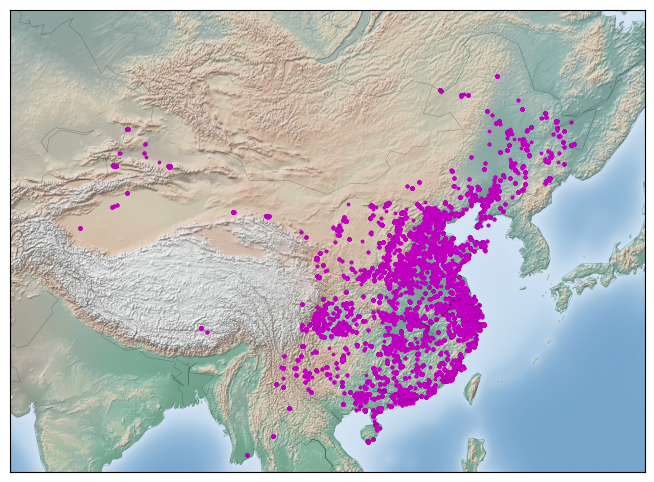

In [10]:
sample_male_locations = regional_locations[regional_locations['gender'] == 'M'].sample(int(1e5))
sample_female_locations = regional_locations[regional_locations['gender'] == 'F'].sample(int(1e5))

map_plot(sample_male_locations, color='b', region_config=region_config)
map_plot(sample_female_locations, color='m', region_config=region_config)

There are more male users East Asia than female users.

### c) Compare the event visualization plots based on the following age groups: 0-24, 25-32, 32+

In [11]:
sample_young_age_locations = regional_locations[regional_locations['age'] < 25].sample(int(1e5))
sample_middle_age_locations = regional_locations[(regional_locations['age'] >= 25) & (regional_locations['age'] < 32)].sample(int(1e5))
sample_old_age_locations = regional_locations[regional_locations['age'] >= 32].sample(int(1e5))

In [12]:
for sample, color in zip(
    [sample_young_age_locations, sample_middle_age_locations, sample_old_age_locations],
    ['r', 'm', 'b'],
):
  map_plot(sample, color=color, region_config=region_config)

Output hidden; open in https://colab.research.google.com to view.

The distribution by age group is not much difference between groups and with the overall distribution.

## 2. DBSCAN clustering as a preprocessing technique

In [13]:
# Clustering based on average location for each device id
regional_locations_by_device = regional_locations.groupby('device_id')[['latitude', 'longitude']].mean().reset_index()
# Clustering the region of interest, others locations will be treated as a different cluster
regional_locations_coord = regional_locations_by_device[['latitude', 'longitude']].values
regional_locations_coord

array([[ 23.19      , 113.24      ],
       [ 30.87151515, 114.36234848],
       [ 46.61897436, 124.88846154],
       ...,
       [ 30.25874693, 120.16542998],
       [ 26.555     , 101.7525    ],
       [ 32.64333333, 118.97333333]])

In [14]:
kms_per_radian = 6371.0088
epsilon = 2.0 / kms_per_radian  # Grouping people within 2 km
db = DBSCAN(
    # cluster_method='dbscan',
    eps=epsilon,
    min_samples=5, # Need 5 neighbors in order to consider a core point
    algorithm = 'ball_tree',
    metric = 'haversine',
    n_jobs=-1, # Use all processors
).fit(np.radians(regional_locations_coord))

location_clusters = pd.Series(db.labels_)
print('Number of clusters:', location_clusters.nunique())
location_clusters

Number of clusters: 224


0        26
1        -1
2        -1
3        -1
4         0
         ..
11552    75
11553    -1
11554    53
11555    -1
11556    -1
Length: 11557, dtype: int64

In [15]:
# Assign cluster labels to train data
regional_locations_by_device['location_cluster'] = location_clusters

# Save core points to another dataframe
dbscan_core_points = regional_locations_by_device[
    regional_locations_by_device['location_cluster'] != -1
][
    ['latitude', 'longitude', 'location_cluster']
]
display(dbscan_core_points.info())
dbscan_core_points

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3066 entries, 0 to 11554
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   latitude          3066 non-null   float64
 1   longitude         3066 non-null   float64
 2   location_cluster  3066 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 95.8 KB


None

,latitude,longitude,location_cluster
0,23.190000,113.240000,26
4,22.660000,114.020000,0
7,22.730000,113.800000,1
9,39.854583,116.300139,2
14,39.110000,117.220000,3
...,...,...,...
11533,22.617500,114.101250,6
11540,31.148548,121.407581,10
11547,30.670000,104.110000,23
11552,41.810000,123.460000,75


In [16]:
# Create feature from location cluster
feature_location_cluster = train_event_data['device_id'].drop_duplicates()
# Merge by device id
feature_location_cluster = pd.merge(
    feature_location_cluster,
    regional_locations_by_device[['device_id', 'location_cluster']],
    on='device_id',
    how='left'
)
feature_location_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74645 entries, 0 to 74644
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   device_id         74645 non-null  int64  
 1   location_cluster  11557 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.7 MB


In [17]:
# Fill all other points with label -1
feature_location_cluster['location_cluster'] = feature_location_cluster['location_cluster'].fillna(-1).astype(int)
feature_location_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74645 entries, 0 to 74644
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   device_id         74645 non-null  int64
 1   location_cluster  74645 non-null  int64
dtypes: int64(2)
memory usage: 1.7 MB


In [18]:
# Save cluster labels
feature_location_cluster.to_csv('data/feature_location_cluster.csv')
os.listdir('data')

['train_mobile_brand.csv',
 'app_events_meta_data.csv',
 'train_event_data.csv',
 'app_events.csv',
 'feature_average_daily_events.csv',
 'train',
 'test',
 'feature_location_cluster.csv']

## 3. Final data preparation and train-test split

### a) Check the datasets and features again to see what columns to include in train/test data

In [19]:
for df, label in zip(
    [
        app_events,
        train_event_data,
        app_events_meta_data,
        train_mobile_brand,
        feature_average_daily_events,
        feature_location_cluster,
    ],
    [
        'app_events',
        'train_event_data',
        'app_events_meta_data',
        'train_mobile_brand',
        'feature_average_daily_events',
        'feature_location_cluster',
    ],
):
  display(HTML(f'<h2>{label} columns:</h2>'))
  display(df.columns.values)
  display(HTML('<hr/>'))

array(['event_id', 'app_id', 'is_installed', 'is_active'], dtype=object)

array(['device_id', 'gender', 'age', 'group_train', 'event_id',
       'datetimestamp', 'latitude', 'longitude'], dtype=object)

array(['app_id', 'label_id', 'category'], dtype=object)

array(['device_id', 'gender', 'age', 'group_train', 'phone_brand',
       'device_model'], dtype=object)

array(['device_id', 'average_daily_events'], dtype=object)

array(['device_id', 'location_cluster'], dtype=object)

### b) Choose features and labels from each data

- `train_event_data`:
  + `device_id`
  + `gender`
  + `age`
  + `event_id` (to split by scenarios: devices with and without events)
- `app_events`: This is the transitive data, so we don't use this
- `app_events_meta_data` (we only use the categories of apps on the device):
  + `device_id` (mapping by `app_id` ↔ `event_id` ↔ `device_id`)
  + `category`
- `train_mobile_brand`:
  + `device_id`
  + `phone_brand`
  + `device_model`
- `feature_average_daily_events`:
  + `device_id`
  + `average_daily_events`
- `feature_location_cluster`:
  + `device_id`
  + `location_cluster`

In [20]:
# Starter records
input_data = train_event_data[['device_id', 'gender', 'age', 'event_id']]

# Show some records
print('number of unique devices:', input_data['device_id'].nunique())
display(input_data.head())

number of unique devices: 74645


,device_id,gender,age,event_id
0,-7548291590301750000,M,33,2369465.0
1,-7548291590301750000,M,33,1080869.0
2,-7548291590301750000,M,33,1079338.0
3,-7548291590301750000,M,33,1078881.0
4,-7548291590301750000,M,33,1068711.0


In [21]:
# Merge with app_events to get the app_id (an event is from a single app)
input_data_with_categories = pd.merge(
    input_data,
    app_events[['app_id', 'event_id']],
    on='event_id',
    how='left',
)
# Merge with app_events_meta_data to get the categories
input_data_with_categories = pd.merge(
    input_data_with_categories,
    # Filter out apps without category before merging
    app_events_meta_data[
        ~app_events_meta_data['category'].isna()
    ][['app_id', 'category']].groupby('app_id').agg(list),
    on='app_id',
    how='left',
).drop(columns=['app_id'])
# Rename category column
input_data_with_categories = input_data_with_categories.rename(
    columns={'category': 'app_categories'},
)
# Merge categories by device
input_data_with_categories = input_data_with_categories.groupby(
    [
        'device_id',
        'gender',
        'age',
    ],
)['app_categories'].agg(
    lambda x: set(element
               for lst in x[~x.isna()]
               for element in lst
              )
).reset_index()
display(input_data_with_categories.info())
input_data_with_categories[input_data_with_categories['app_categories'].apply(lambda x: len(x) > 0)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74645 entries, 0 to 74644
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   device_id       74645 non-null  int64 
 1   gender          74645 non-null  object
 2   age             74645 non-null  int64 
 3   app_categories  74645 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


None

,device_id,gender,age,app_categories
23,-9217193238265890000,M,33,{Technology Information}
44,-9212412905070440000,M,33,{Integrated Living}
80,-9201434269962940000,M,35,{video}
91,-9198513807097370000,M,22,{Contacts}
114,-9192503757087420000,M,41,{Technology Information}
...,...,...,...,...
74537,9198782493894550000,M,23,{Technology Information}
74578,9207229814361450000,F,29,{Taxi}
74580,9207308632673860000,F,24,{Contacts}
74621,9216925254504440000,M,41,{Technology Information}


In [22]:
# Merge the phone_brand feature
input_data_with_categories_and_phone_brand = pd.merge(
    input_data_with_categories,
    train_mobile_brand[['device_id', 'phone_brand', 'device_model']],
    on='device_id',
    how='left',
)

display(input_data_with_categories_and_phone_brand.info())
input_data_with_categories_and_phone_brand

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74840 entries, 0 to 74839
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   device_id       74840 non-null  int64 
 1   gender          74840 non-null  object
 2   age             74840 non-null  int64 
 3   app_categories  74840 non-null  object
 4   phone_brand     74840 non-null  object
 5   device_model    74840 non-null  object
dtypes: int64(2), object(4)
memory usage: 4.0+ MB


None

,device_id,gender,age,app_categories,phone_brand,device_model
0,-9223067244542180000,M,24,{},vivo,Y19T
1,-9222956879900150000,M,36,{},samsung,Galaxy Note 2
2,-9222754701995930000,M,29,{},Coolpad,8730L
3,-9222352239947200000,M,23,{},Xiaomi,xnote11
4,-9222173362545970000,F,56,{},samsung,Galaxy Note 2
...,...,...,...,...,...,...
74835,9220914901466450000,M,34,{},Meizu,MX4 Pro
74836,9221152396628730000,M,21,{},Xiaomi,MI 2S
74837,9221608286127660000,F,43,{},OPPO,R1
74838,9221843411551060000,M,17,{},Gionee,E5


In [23]:
# Merge the newly created features
input_data_with_full_details = pd.merge(
    input_data_with_categories_and_phone_brand,
    feature_average_daily_events,
    on='device_id',
    how='left',
)
input_data_with_full_details = pd.merge(
    input_data_with_full_details,
    feature_location_cluster,
    on='device_id',
    how='left',
)
input_data_with_full_details.set_index('device_id')
display(input_data_with_full_details.info())
input_data_with_full_details

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74840 entries, 0 to 74839
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   device_id             74840 non-null  int64  
 1   gender                74840 non-null  object 
 2   age                   74840 non-null  int64  
 3   app_categories        74840 non-null  object 
 4   phone_brand           74840 non-null  object 
 5   device_model          74840 non-null  object 
 6   average_daily_events  23402 non-null  float64
 7   location_cluster      74840 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 5.1+ MB


None

,device_id,gender,age,app_categories,phone_brand,device_model,average_daily_events,location_cluster
0,-9223067244542180000,M,24,{},vivo,Y19T,NaN,-1
1,-9222956879900150000,M,36,{},samsung,Galaxy Note 2,4.524564e+07,26
2,-9222754701995930000,M,29,{},Coolpad,8730L,NaN,-1
3,-9222352239947200000,M,23,{},Xiaomi,xnote11,NaN,-1
4,-9222173362545970000,F,56,{},samsung,Galaxy Note 2,NaN,-1
...,...,...,...,...,...,...,...,...
74835,9220914901466450000,M,34,{},Meizu,MX4 Pro,8.211310e+06,-1
74836,9221152396628730000,M,21,{},Xiaomi,MI 2S,NaN,-1
74837,9221608286127660000,F,43,{},OPPO,R1,NaN,-1
74838,9221843411551060000,M,17,{},Gionee,E5,NaN,-1


The data is ok and is ready for next step.

### c) Tagging records by scenarios
- Scenario 1: All features are available
- Scenario 2: Only basic features about device are available

In [24]:
segment_tag = (
    input_data_with_full_details['app_categories'].apply(lambda lst: len(lst) > 0) &
    (~input_data_with_full_details['average_daily_events'].isna())
).apply(lambda x: 1 if x else 2)
input_data_segment_tagged = input_data_with_full_details.copy()
input_data_segment_tagged['segment'] = segment_tag
input_data_segment_tagged = input_data_segment_tagged
display(input_data_segment_tagged.info())
input_data_segment_tagged

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74840 entries, 0 to 74839
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   device_id             74840 non-null  int64  
 1   gender                74840 non-null  object 
 2   age                   74840 non-null  int64  
 3   app_categories        74840 non-null  object 
 4   phone_brand           74840 non-null  object 
 5   device_model          74840 non-null  object 
 6   average_daily_events  23402 non-null  float64
 7   location_cluster      74840 non-null  int64  
 8   segment               74840 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 5.7+ MB


None

,device_id,gender,age,app_categories,phone_brand,device_model,average_daily_events,location_cluster,segment
0,-9223067244542180000,M,24,{},vivo,Y19T,NaN,-1,2
1,-9222956879900150000,M,36,{},samsung,Galaxy Note 2,4.524564e+07,26,2
2,-9222754701995930000,M,29,{},Coolpad,8730L,NaN,-1,2
3,-9222352239947200000,M,23,{},Xiaomi,xnote11,NaN,-1,2
4,-9222173362545970000,F,56,{},samsung,Galaxy Note 2,NaN,-1,2
...,...,...,...,...,...,...,...,...,...
74835,9220914901466450000,M,34,{},Meizu,MX4 Pro,8.211310e+06,-1,2
74836,9221152396628730000,M,21,{},Xiaomi,MI 2S,NaN,-1,2
74837,9221608286127660000,F,43,{},OPPO,R1,NaN,-1,2
74838,9221843411551060000,M,17,{},Gionee,E5,NaN,-1,2


### d) Preprocess feature columns

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, FunctionTransformer, StandardScaler, LabelEncoder

In [26]:
# Reference: https://github.com/scikit-learn/scikit-learn/issues/11309#issuecomment-1528042914
from typing import Any, Callable, Sequence
from typing_extensions import Self
import numpy.typing as npt

from sklearn.base import BaseEstimator, TransformerMixin

# Transform app categories
class MultiHotEncoder(BaseEstimator, TransformerMixin):
    """Wraps `MultiLabelBinarizer` in a form that can work with `ColumnTransformer`. It makes it accept multiple inputs.

    Note that the input `X` has to be a `pandas.DataFrame`.
    """

    def __init__(self, binarizer_creator: Callable[[], Any] | None = None, dtype: npt.DTypeLike | None = None) -> None:
        # Import inside function to prevent issues with pickling
        from sklearn.preprocessing import MultiLabelBinarizer

        self.binarizer_creator = binarizer_creator or MultiLabelBinarizer
        self.dtype = dtype

        self.binarizers = []
        self.categories_ = self.classes_ = []
        self.columns = []

    def fit(self, X: pd.DataFrame, y: Any = None) -> Self:  # noqa
        self.columns = X.columns.to_list()

        for column_name in X:
            binarizer = self.binarizer_creator().fit(X[column_name])
            self.binarizers.append(binarizer)
            self.classes_.append(binarizer.classes_)  # noqa

        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        # Import inside function to prevent issues with pickling
        import numpy as np
        from sklearn.utils.validation import check_is_fitted

        check_is_fitted(self)

        if len(self.classes_) != X.shape[1]:
            raise ValueError(f"The fit transformer deals with {len(self.classes_)} columns "
                             f"while the input has {X.shape[1]}.")

        return np.concatenate([binarizer.transform(X[c]).astype(self.dtype)
                               for c, binarizer in zip(X, self.binarizers)], axis=1)

    def get_feature_names_out(self, input_features: Sequence[str] = None) -> np.ndarray:
        # Import inside function to prevent issues with pickling
        import numpy as np
        from sklearn.utils.validation import check_is_fitted

        check_is_fitted(self)

        cats = self.categories_

        if input_features is None:
            input_features = self.columns
        elif len(input_features) != len(self.categories_):
            raise ValueError(f"input_features should have length equal to number of features ({len(self.categories_)}),"
                             f" got {len(input_features)}")

        return np.asarray([input_features[i] + "_" + str(t) for i in range(len(cats)) for t in cats[i]])

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Multi-label encode app categories
mlb_transform = ColumnTransformer(
    transformers=[
        ('mlb', MultiHotEncoder(), ['app_categories']),
    ],
    verbose_feature_names_out=False, # if True, "mlb_" will be prefixed to the column names that have been transformed
    remainder='passthrough' # this allows columns not being transformed to pass through unchanged
)
mlb_transform.set_output(transform='pandas')

# One-hot encode other category columns
ohe_transform = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), ['location_cluster', 'phone_brand', 'device_model']),
    ],
    verbose_feature_names_out=False, # if True, "ohe_" will be prefixed to the column names that have been transformed
    remainder='passthrough' # this allows columns not being transformed to pass through unchanged
)
ohe_transform.set_output(transform='pandas')

# Log transform average_daily_events
log_transform = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p), ['average_daily_events']),
    ],
    verbose_feature_names_out=False, # if True, "log_" will be prefixed to the column names that have been transformed
    remainder='passthrough' # this allows columns not being transformed to pass through unchanged
)
log_transform.set_output(transform='pandas')

# Scale transform average_daily_events
scale_transform = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), ['average_daily_events']),
    ],
    verbose_feature_names_out=False, # if True, "scale_" will be prefixed to the column names that have been transformed
    remainder='passthrough' # this allows columns not being transformed to pass through unchanged
)
scale_transform.set_output(transform='pandas')

# Preprocessing pipeline, need to save this for usage later in deployment
preprocessor = make_pipeline(
    mlb_transform,
    ohe_transform,
    log_transform,
    scale_transform,
)

preprocessed_data = preprocessor.fit_transform(
    input_data_segment_tagged[
        [col
         for col in input_data_segment_tagged
         if col not in ('device_id', 'gender', 'age', 'segment')
        ]
    ]
)
display(preprocessed_data.info())
preprocessed_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74840 entries, 0 to 74839
Columns: 1856 entries, average_daily_events to app_categories_zombies game
dtypes: float64(1856)
memory usage: 1.0 GB


None

,average_daily_events,location_cluster_-1,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,...,app_categories_quality,app_categories_reading platform,app_categories_realistic style comic,app_categories_service,app_categories_show,app_categories_takeaway ordering,app_categories_tourism product,app_categories_travel,app_categories_video,app_categories_zombies game
0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.488142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74835,0.124423,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74836,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74837,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74838,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### e) Format labels

- For gender, we will use logistic regression.
- For age, since business problem is to make targeted ads to customers, it's better to group them into age groups and then select ads based on the group.

In [28]:
# Add device_id back
preprocessed_data['device_id'] = input_data_segment_tagged['device_id']

# Categorizing ages into groups
preprocessed_data['age_group'] = pd.cut(input_data_segment_tagged['age'], [0, 24, 32, 45, np.Inf])

# Label-encoding gender and age columns
# Need to save the encoders into files for deployment later
gender_label_encoder = LabelEncoder()
age_label_encoder = LabelEncoder()

preprocessed_data['gender'] = gender_label_encoder.fit_transform(input_data_segment_tagged['gender'])
preprocessed_data['age_group'] = age_label_encoder.fit_transform(preprocessed_data['age_group'])
preprocessed_data

,average_daily_events,location_cluster_-1,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,...,app_categories_service,app_categories_show,app_categories_takeaway ordering,app_categories_tourism product,app_categories_travel,app_categories_video,app_categories_zombies game,device_id,age_group,gender
0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9223067244542180000,0,1
1,1.488142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9222956879900150000,2,1
2,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9222754701995930000,1,1
3,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9222352239947200000,0,1
4,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9222173362545970000,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74835,0.124423,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9220914901466450000,2,1
74836,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9221152396628730000,0,1
74837,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9221608286127660000,2,0
74838,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9221843411551060000,0,1


### f) Train test split

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
# Segment by scenarios before splitting to ensure the percentage of splits
segment_1 = preprocessed_data[input_data_segment_tagged['segment'] == 1]
segment_1 = segment_1.reset_index(drop=True)
segment_2 = preprocessed_data[input_data_segment_tagged['segment'] == 2]
segment_2 = segment_2[['device_id', 'gender', 'age_group', *[col for col in segment_2.columns if col.startswith('phone_brand_')]]]
segment_2 = segment_2.reset_index(drop=True)

for df, label in zip(
    [
        segment_1,
        segment_2,
    ],
    [
        'segment_1',
        'segment_2',
    ],
):
    display(HTML(f'<h2>{label}</h2>'))
    display(df)

,average_daily_events,location_cluster_-1,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,...,app_categories_service,app_categories_show,app_categories_takeaway ordering,app_categories_tourism product,app_categories_travel,app_categories_video,app_categories_zombies game,device_id,age_group,gender
0,-2.113998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9217193238265890000,2,1
1,-0.045799,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9212412905070440000,2,1
2,-1.301406,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-9201434269962940000,2,1
3,-0.474263,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9198513807097370000,0,1
4,-0.474263,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9198513807097370000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4054,-0.613401,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9198782493894550000,0,1
4055,-0.514947,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9207229814361450000,1,0
4056,-0.714326,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9207308632673860000,0,0
4057,1.153500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9216925254504440000,2,1


,device_id,gender,age_group,phone_brand_AUX,phone_brand_Bacardi,phone_brand_Bifer,phone_brand_CUBE,phone_brand_Changhong,phone_brand_Cong,phone_brand_Coolpad,...,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,-9223067244542180000,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-9222956879900150000,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-9222754701995930000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-9222352239947200000,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-9222173362545970000,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70776,9220914901466450000,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70777,9221152396628730000,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70778,9221608286127660000,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70779,9221843411551060000,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# Train/test split
(
    segment_1_train,
    segment_1_test,
) = train_test_split(
    segment_1,
    test_size=.3,
    random_state=0,
)
(
    segment_2_train,
    segment_2_test,
) = train_test_split(
    segment_2,
    test_size=.3,
    random_state=0,
)

for df, label in zip(
    [
        segment_1_train,
        segment_1_test,
        segment_2_train,
        segment_2_test,
    ],
    [
        'segment_1_train',
        'segment_1_test',
        'segment_2_train',
        'segment_2_test',
    ],
):
    df = df.reset_index(drop=True)
    display(HTML(f'<h2>{label}</h2>'))
    print('shape:', df.shape)
    display(df)

shape: (2841, 1859)


,average_daily_events,location_cluster_-1,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,...,app_categories_service,app_categories_show,app_categories_takeaway ordering,app_categories_tourism product,app_categories_travel,app_categories_video,app_categories_zombies game,device_id,age_group,gender
0,0.380427,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-245720156210362000,2,1
1,-0.621224,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,933122217477149000,2,1
2,-2.669088,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2045942311285540000,0,1
3,1.157734,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1139946497677110000,2,1
4,-0.123856,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-250105551027878000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836,-0.623716,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-5351149996525750000,2,1
2837,1.288079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5730785014341770000,1,1
2838,-0.705781,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1611279826669790000,0,0
2839,-0.026953,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2686743327808270000,2,1


shape: (1218, 1859)


,average_daily_events,location_cluster_-1,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,...,app_categories_service,app_categories_show,app_categories_takeaway ordering,app_categories_tourism product,app_categories_travel,app_categories_video,app_categories_zombies game,device_id,age_group,gender
0,2.356397,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4968154927622700000,3,0
1,-0.523348,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5164709194749140000,1,1
2,0.073159,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-446534884923407000,1,1
3,1.744514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4929004728683190000,3,1
4,1.057478,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-6540623292245040000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,0.480375,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3558602119006800000,1,0
1214,-0.893056,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3049092807223440000,2,0
1215,0.478324,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4610975622206370000,1,1
1216,-0.013296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6339023951586040000,1,1


shape: (49546, 100)


,device_id,gender,age_group,phone_brand_AUX,phone_brand_Bacardi,phone_brand_Bifer,phone_brand_CUBE,phone_brand_Changhong,phone_brand_Cong,phone_brand_Coolpad,...,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,5563127744213600000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-8049553530811300000,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4042086948304470000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-679142927640773000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8085592460854130000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49541,-3695505048429830000,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49542,2733856391065410000,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49543,1885626787384140000,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49544,2130080773515700000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape: (21235, 100)


,device_id,gender,age_group,phone_brand_AUX,phone_brand_Bacardi,phone_brand_Bifer,phone_brand_CUBE,phone_brand_Changhong,phone_brand_Cong,phone_brand_Coolpad,...,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,-191669847070955000,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2403589567148540000,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4604662545429270000,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4019394794123470000,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1021613832219450000,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21230,3557324664602540000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21231,-931978254629029000,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21232,-2171067714073140000,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21233,-7956453462733460000,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### g) Test case to make sure the encoders can be used in deployment

In [32]:
# Test data to use in deployment
deploy_data = input_data_segment_tagged.loc[input_data_segment_tagged['device_id'].isin(segment_1_test['device_id'])]
deploy_data = pd.merge(
    deploy_data,
    train_event_data[['device_id', 'latitude', 'longitude']],
    on='device_id',
    how='left',
)

In [33]:
test_input_data = deploy_data.loc[0]
test_input_data = test_input_data.to_json()
test_input_data

'{"device_id":-9212412905070440000,"gender":"M","age":33,"app_categories":["Integrated Living"],"phone_brand":"Meizu","device_model":"\\u00e9\\u00ad\\u2026\\u00e8\\u201c\\u009d2","average_daily_events":6635879.4285714282,"location_cluster":-1,"segment":1,"latitude":0.0,"longitude":0.0}'

In [34]:
class InputProcessor:
    '''
    Copy this class definition to
    '''
    def __init__(self, preprocessor, dbscan_core_points):
        self.epsilon = 2.0 / 6371.0088  # Grouping people within 2 km
        self.preprocessor = preprocessor
        self.dbscan_core_points = dbscan_core_points

    def find_location_cluster(self, coord):
        '''
        Find cluster labels for new points.
        If the point is within epsilon distance to a core point then we give
        the core point's label to that point.
        '''
        # Import inside function to prevent issues with pickling
        import numpy as np
        from sklearn.metrics.pairwise import haversine_distances

        distances = haversine_distances(
            np.radians(self.dbscan_core_points[['latitude', 'longitude']]),
            np.radians(coord),
        )
        location_clusters = self.dbscan_core_points[distances < self.epsilon]['location_cluster'].mode()
        label = location_clusters[0] if location_clusters.shape[0] else -1
        return label


    def process_input(self, json_str):
        '''
        Process json input string to the dataframe that model can consume.
        Example:
            {
                'app_categories': ['video', 'zombies game'],
                'phone_brand': 'Xiaomi',
                'device_model': 'MI 4',
                'average_daily_events': 45245644.5,
                'latitude': 22.660000,
                'longitude': 114.020000,
            }
        '''
        # Import inside function to prevent issues with pickling
        import pandas as pd

        df = pd.read_json(json_str, lines=True, nrows=1)
        df['location_cluster'] = self.find_location_cluster(df[['latitude', 'longitude']])
        df = self.preprocessor.transform(df)
        return df

input_processor = InputProcessor(preprocessor, dbscan_core_points)
processed_test_data = input_processor.process_input(test_input_data)
display(processed_test_data.columns)
processed_test_data

Index(['average_daily_events', 'location_cluster_-1', 'location_cluster_0',
       'location_cluster_1', 'location_cluster_2', 'location_cluster_3',
       'location_cluster_4', 'location_cluster_5', 'location_cluster_6',
       'location_cluster_7',
       ...
       'app_categories_quality', 'app_categories_reading platform',
       'app_categories_realistic style comic', 'app_categories_service',
       'app_categories_show', 'app_categories_takeaway ordering',
       'app_categories_tourism product', 'app_categories_travel',
       'app_categories_video', 'app_categories_zombies game'],
      dtype='object', length=1856)

,average_daily_events,location_cluster_-1,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4,location_cluster_5,location_cluster_6,location_cluster_7,...,app_categories_quality,app_categories_reading platform,app_categories_realistic style comic,app_categories_service,app_categories_show,app_categories_takeaway ordering,app_categories_tourism product,app_categories_travel,app_categories_video,app_categories_zombies game
0,-0.045799,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As we can see above, total number of columns (together with gender, age and average_daily_events) is 1858, which is correct.

### h) Save transformer and train/test data for later and for deployment

In [35]:
import dill

In [36]:
# Save encoders for using later in deployment
os.makedirs('deploy', exist_ok=True)


with open('deploy/input_processor.pickle', 'wb') as f:
  dill.dump(input_processor, f)

with open('deploy/gender_label_encoder.pickle', 'wb') as f:
  dill.dump(gender_label_encoder, f)

with open('deploy/age_label_encoder.pickle', 'wb') as f:
  dill.dump(age_label_encoder, f)

# Save train/test data for model training
os.makedirs('data/train', exist_ok=True)
os.makedirs('data/test', exist_ok=True)

segment_1_train.to_csv('data/train/segment_1_train.csv', index=False)
segment_1_test.to_csv('data/test/segment_1_test.csv', index=False)
segment_2_train.to_csv('data/train/segment_2_train.csv', index=False)
segment_2_test.to_csv('data/test/segment_2_test.csv', index=False)

# Save the data that will be used in deployment
deploy_data.to_csv('deploy/deploy_data.csv', index=False)

In [37]:
for d in ('deploy', 'data/train', 'data/test'):
    print(d)
    display(os.listdir(d))

deploy


['gender_model_sc1_fit.pickle',
 'gender_model_sc2_fit.pickle',
 'age_model_sc1_fit.pickle',
 'age_model_sc2_fit.pickle',
 'input_processor.pickle',
 'age_label_encoder.pickle',
 'gender_label_encoder.pickle',
 'deploy_data.csv']

data/train


['segment_1_train.csv', 'segment_2_train.csv']

data/test


['segment_1_test.csv', 'segment_2_test.csv']